In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
dataset = pd.read_csv('mbti_1.csv') 
dataset.head()


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
print(dataset.columns)

Index(['type', 'posts'], dtype='object')


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load stopwords once outside the function to improve performance
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from joblib import Parallel, delayed

# Preprocessing function
def preprocess_posts(posts):
    # Replace '|||' with a space (if you want to split posts into separate samples, apply this step)
    posts = posts.replace('|||', ' ')
    
    # Remove URLs and special characters in one step
    posts = re.sub(r'http\S+|www\S+|[^A-Za-z\s]', '', posts)
    
    # Convert to lowercase
    posts = posts.lower()
    
    # Tokenize the text
    tokens = word_tokenize(posts)
    
    # Remove stopwords and lemmatize in one pass
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    return ' '.join(tokens)

# Function to process a single post
def process_single_post(post):
    return preprocess_posts(post)

# Parallelize the process
dataset['cleaned_posts'] = Parallel(n_jobs=-1)(delayed(process_single_post)(post) for post in dataset['posts'])

In [6]:
# Map MBTI to Big Five traits
def map_to_big_five(mbti):
    traits = {
        'I': 1, 'E': 0,  # Introversion (1) vs. Extraversion (0)
        'N': 1, 'S': 0,  # Openness (1) vs. Sensing (0)
        'F': 1, 'T': 0,  # Agreeableness (1) vs. Thinking (0)
        'P': 1, 'J': 0   # Conscientiousness (1) vs. Judging (0)
    }
    return [
        traits[mbti[0]],  # I/E
        traits[mbti[1]],  # S/N
        traits[mbti[2]],  # T/F
        traits[mbti[3]]   # J/P
    ]

# Apply mapping
dataset[['introversion', 'openness', 'agreeableness', 'conscientiousness']] = dataset['type'].apply(map_to_big_five).tolist()


In [10]:
dataset = dataset[dataset['posts'].str.len() > 20]
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
features = tfidf.fit_transform(dataset['cleaned_posts'])

In [13]:
from sklearn.metrics import confusion_matrix
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, dataset['type'], test_size=0.2, random_state=42)

from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

C:\Users\farru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

        ENFJ       0.58      0.34      0.43        41
        ENFP       0.60      0.58      0.59       125
        ENTJ       0.66      0.48      0.55        44
        ENTP       0.56      0.57      0.56       135
        ESFJ       0.00      0.00      0.00         7
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00         7
        ESTP       0.71      0.33      0.45        15
        INFJ       0.59      0.62      0.61       288
        INFP       0.68      0.77      0.72       370
        INTJ       0.58      0.65      0.61       193
        INTP       0.65      0.73      0.69       293
        ISFJ       0.79      0.51      0.62        45
        ISFP       0.69      0.47      0.56        53
        ISTJ       0.63      0.39      0.48        44
        ISTP       0.64      0.54      0.59        67

    accuracy                           0.63      1735
   macro avg       0.52   

C:\Users\farru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,


    Predicted Personality: INTP
    Summary: The Thinker - Logical, analytical, and abstract.
    
    Preference Pairs:
    E/I: Introversion - Focuses on the inner world and reflective thoughts.
S/N: Intuition - Prefers abstract ideas over facts.
T/F: Thinking - Prioritizes objectivity and logical consistency.
J/P: Perceiving - Prefers flexibility, spontaneous and adaptable.
    


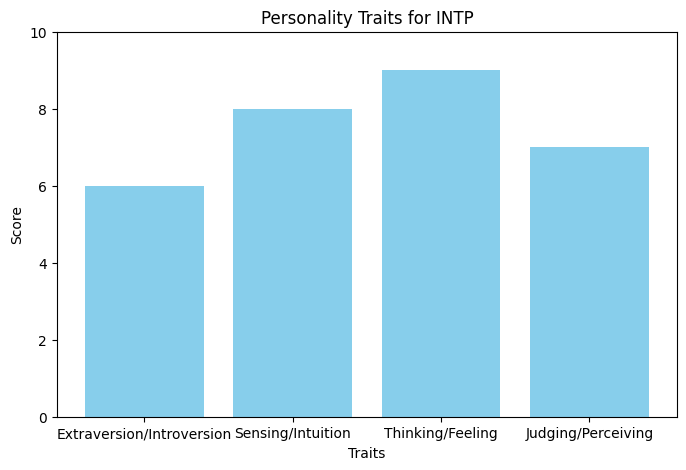

In [18]:
import matplotlib.pyplot as plt
# Personality descriptions and preferences
personality_descriptions = {
    'INFJ': {
        'summary': "The Advocate - Quiet, mystical, idealistic, and creative.",
        'preferences': {
            'E/I': "Introversion - Focuses on the inner world and reflective thoughts.",
            'S/N': "Intuition - Prefers to focus on the big picture and abstract ideas.",
            'T/F': "Feeling - Decides empathetically, values harmony.",
            'J/P': "Judging - Seeks closure, organized and planned."
        },
        'trait_scores': [7, 8, 9, 8]  # Example scores for visualization
    },
    'ENTP': {
        'summary': "The Debater - Energetic, innovative, and loves intellectual debates.",
        'preferences': {
            'E/I': "Extraversion - Directs energy outward, enjoys social interactions.",
            'S/N': "Intuition - Focuses on the big picture, innovative and curious.",
            'T/F': "Thinking - Decides objectively, values logic.",
            'J/P': "Perceiving - Stays open to new information, spontaneous."
        },
        'trait_scores': [9, 7, 8, 6]  # Example scores for visualization
    },
    'INTP': {
        'summary': "The Thinker - Logical, analytical, and abstract.",
        'preferences': {
            'E/I': "Introversion - Focuses on the inner world and reflective thoughts.",
            'S/N': "Intuition - Prefers abstract ideas over facts.",
            'T/F': "Thinking - Prioritizes objectivity and logical consistency.",
            'J/P': "Perceiving - Prefers flexibility, spontaneous and adaptable."
        },
        'trait_scores': [6, 8, 9, 7]  # Example scores for visualization
    }
}

# Prediction function
def predict_personality(text):
    cleaned_text = text.lower().replace(r'[^a-z\s]', '')
    vectorized_text = tfidf.transform([cleaned_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction

# Visualization function
def visualize_personality(personality_type):
    details = personality_descriptions.get(personality_type, {})
    if not details:
        print("No details available for this personality type.")
        return
    
    traits = ['Extraversion/Introversion', 'Sensing/Intuition', 'Thinking/Feeling', 'Judging/Perceiving']
    scores = details['trait_scores']
    
    plt.figure(figsize=(8, 5))
    plt.bar(traits, scores, color='skyblue')
    plt.ylim(0, 10)
    plt.title(f'Personality Traits for {personality_type}')
    plt.xlabel('Traits')
    plt.ylabel('Score')
    plt.show()

# Generate output
def generate_output(personality_type):
    details = personality_descriptions.get(personality_type, {})
    if not details:
        return "No details available for this personality type."
    
    summary = details['summary']
    preferences = "\n".join(
        [f"{key}: {value}" for key, value in details['preferences'].items()]
    )
    
    return f"""
    Predicted Personality: {personality_type}
    Summary: {summary}
    
    Preference Pairs:
    {preferences}
    """

# User input
user_input = "I enjoy debating and coming up with creative solutions."
predicted_type = predict_personality(user_input)

# Output results
output = generate_output(predicted_type)
print(output)

# Visualize results
visualize_personality(predicted_type)